In [1]:
from main.compiling.compilers.AncillaPerCheckCompiler import AncillaPerCheckCompiler
from main.compiling.noise.models.CircuitLevelNoise import CircuitLevelNoise
from main.compiling.syndrome_extraction.extractors.ancilla_per_check.mixed.CxCyCzExtractor import CxCyCzExtractor
from main.codes.tic_tac_toe.HoneycombCode import HoneycombCode
from main.codes.tic_tac_toe.gauge_honeycomb_code import GaugeHoneycombCode
from main.codes.tic_tac_toe.FloquetColourCode import FloquetColourCode
from main.codes.tic_tac_toe.TicTacToeCode import TicTacToeCode
from main.utils.enums import State
from main.building_blocks.pauli import Pauli
from main.building_blocks.pauli.PauliLetter import PauliLetter
import stim
import sinter 
import matplotlib.pyplot as plt
import numpy as np
from beliefmatching import BeliefMatchingSinterDecoder
from main.utils.Colour import Blue, Green, Red
import os
from phenomenological_noise_experiments.threshold_plot import *
from sinter._csv_out import CSV_HEADER




## Import and compress data

In [152]:
os.system(f"cp data_7_8/combined_data_new.csv data_7_8/combined_data_backup.csv")
os.system(f"sinter combine resume_31_7_extra/data_Gauge3HoneycombCode.csv data_7_8/combined_data_new.csv > data_7_8/combined_data_newest.csv")

samples = sinter.stats_from_csv_files('data_7_8/combined_data_newest.csv')
biases = []

for sample in samples:
    if sample.json_metadata['bias'] not in biases:
        biases.append(sample.json_metadata['bias'])
biases.sort()

all_thresholds_hcc = dict()
all_thresholds_fcc = dict()
all_thresholds_hcc['pymatching'] = dict()
all_thresholds_hcc['beliefmatching'] = dict()
all_thresholds_fcc['pymatching'] = dict()
all_thresholds_fcc['beliefmatching'] = dict()

### Depolarizing vs measurement noise with gauge fixing

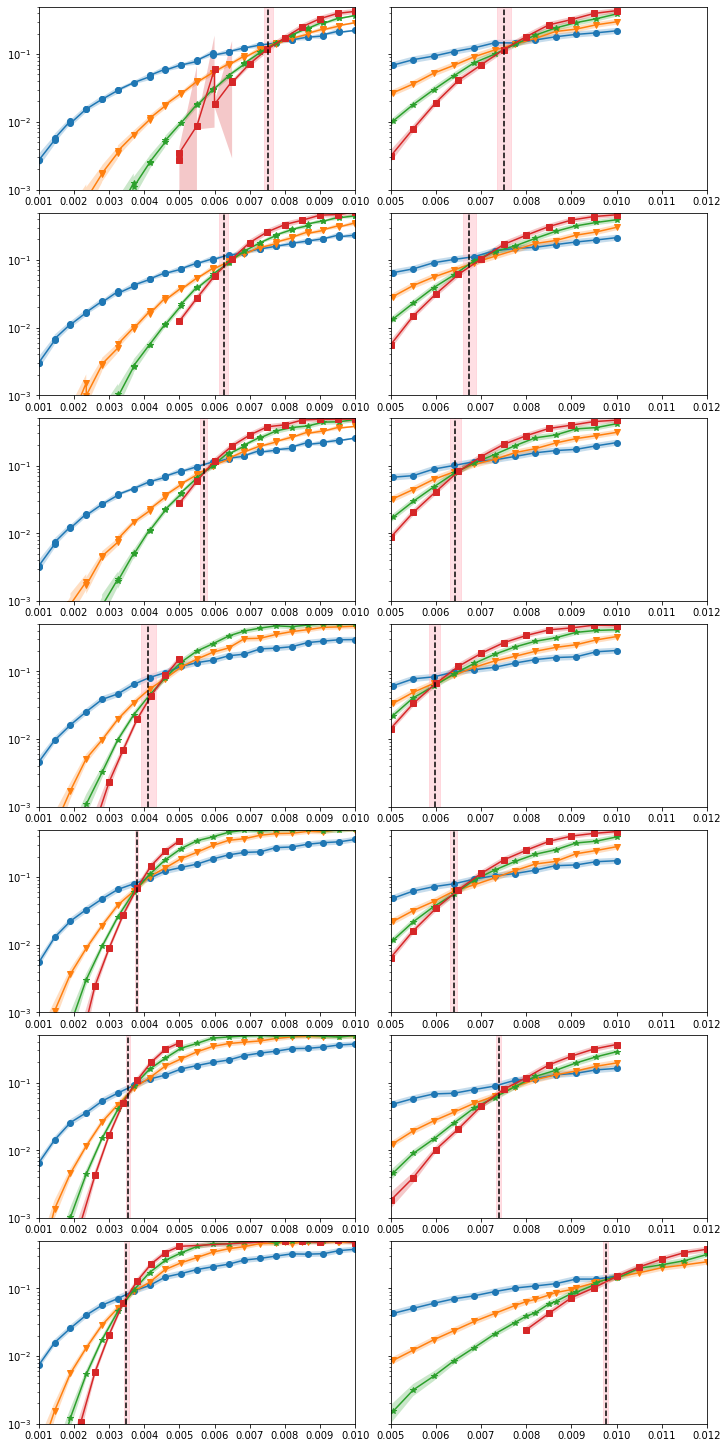

In [153]:
fig, axis = plt.subplots(7, 2, figsize=(10, 20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()

def plot_threshold(ax, stats, filter_func, min_per, max_per, min_dis):  # , filter_func, x_func):
    sinter.plot_error_rate(
        ax=ax,
        stats=stats,
        group_func=lambda stat: f"d={stat.json_metadata['distance']}",
        filter_func=filter_func,
        x_func=lambda stat: stat.json_metadata['p'])
    ax.set_yscale('log')
    thresholds, err = get_one_threshold(stats, filter_func, 1, min_per, max_per, min_dis)
    ax.axvline(x=thresholds, color="black", linestyle="dashed")
    ax.axvspan(
               thresholds-err, thresholds+err, alpha=0.5, color='pink'
            )
    return thresholds, err

axis[0][0].set_ylim(0.001, 0.5)

for index, bias in enumerate(biases):
    def filter_func_hcc(s): return s.decoder == 'pymatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata[
        'bias'] == bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'

    def filter_func_fcc(s): return s.decoder == 'pymatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata[
        'bias'] == bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
    for ax in axis[index]:

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                        ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(10)
    if bias < 7:
        thresholds_hcc[bias] = plot_threshold(axis[index][0], samples, filter_func_hcc, 0.001,0.01,5)
        thresholds_fcc[bias] = plot_threshold(axis[index][1], samples, filter_func_fcc, 0.001,0.01,5)    

    elif bias < 100:
        thresholds_hcc[bias] = plot_threshold(axis[index][0], samples, filter_func_hcc, 0.003, 0.007, 5)
        thresholds_fcc[bias] = plot_threshold(axis[index][1], samples, filter_func_fcc, 0.004, 0.012, 5)
        
    else:
        thresholds_hcc[bias] = plot_threshold(axis[index][0], samples, filter_func_hcc,  0.003, 0.07, 5)
        thresholds_fcc[bias] = plot_threshold(axis[index][1], samples, filter_func_fcc,  0.005, 0.015, 5)


    axis[index][0].set_xlim(0.001, 0.01)
    axis[index][1].set_xlim(0.005, 0.012)
all_thresholds_hcc['pymatching']['depolarizing_vs_measurement'] = thresholds_hcc
all_thresholds_fcc['pymatching']['depolarizing_vs_measurement'] = thresholds_fcc


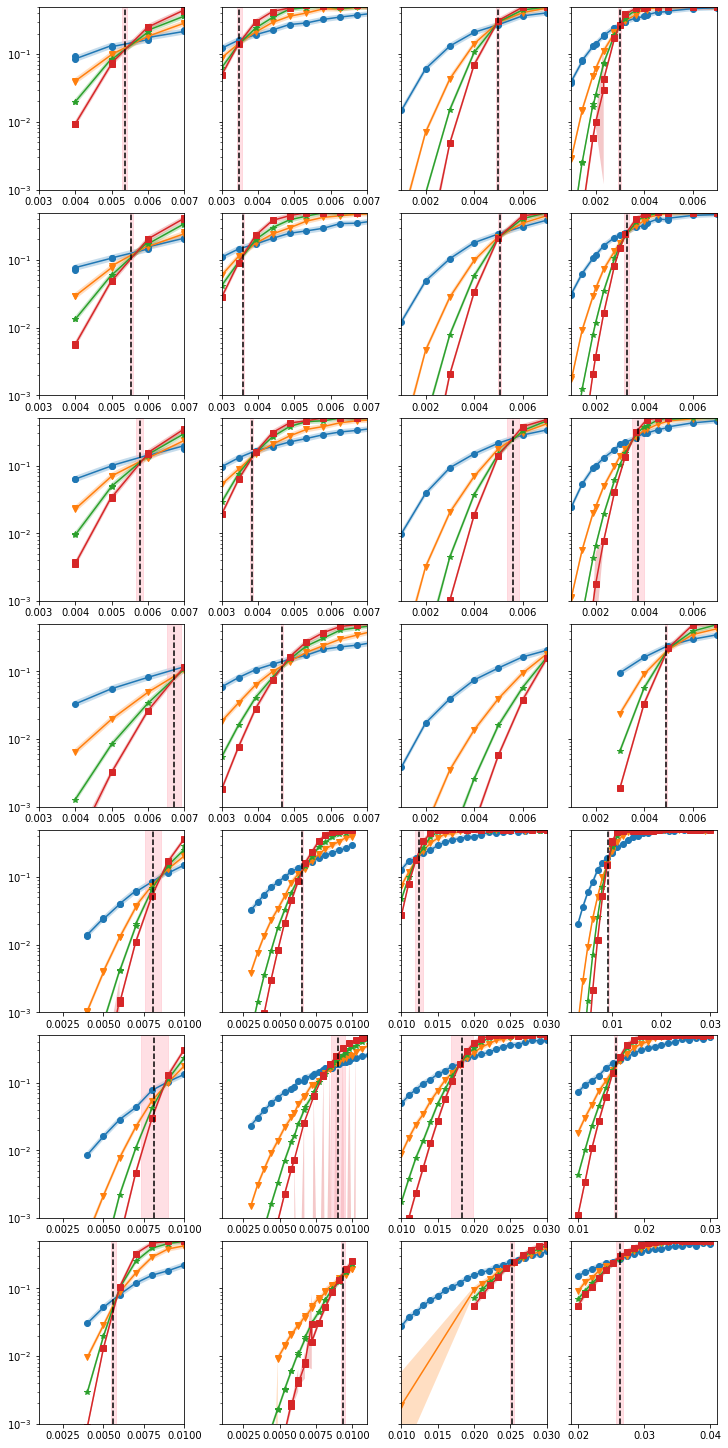

In [162]:
fig, axis = plt.subplots(7,4,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_fcc2 = dict()
thresholds_fcc3 = dict()
thresholds_hcc3 = dict()
thresholds_hcc2 = dict()
axis[0][0].set_ylim(0.001, 0.5)

for index,bias in enumerate(biases):
    filter_func_fccg2 = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'Gauge2FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
    filter_func_fccg3 = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'Gauge3FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
    filter_func_hccg2 = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'Gauge2HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
    filter_func_hccg3 = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'Gauge3HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'

    if bias < 7:
        thresholds_hcc2[bias] = plot_threshold(axis[index][0], samples, filter_func_hccg2, 0.003, 0.008, 5)
        thresholds_hcc3[bias]= plot_threshold(axis[index][1], samples, filter_func_hccg3, 0.003, 0.008,5)
        thresholds_fcc2[bias] = plot_threshold(axis[index][2], samples, filter_func_fccg2, 0.002, 0.009,5)
        thresholds_fcc3[bias] = plot_threshold(axis[index][3], samples, filter_func_fccg3, 0.001, 0.006, 5)

        axis[index][0].set_xlim(0.003, 0.007)
        axis[index][1].set_xlim(0.003, 0.007)
        axis[index][2].set_xlim(0.001, 0.007)
        axis[index][3].set_xlim(0.001, 0.007)
    else:
        thresholds_hcc2[bias] = plot_threshold(axis[index][0], samples, filter_func_hccg2, 0.003, 0.01, 5)
        thresholds_hcc3[bias] = plot_threshold(axis[index][1], samples, filter_func_hccg3, 0.006, 0.009,5)
        thresholds_fcc2[bias] = plot_threshold(axis[index][2], samples, filter_func_fccg2, 0.005, 0.03,5)
        thresholds_fcc3[bias] = plot_threshold(axis[index][3], samples, filter_func_fccg3, 0.005, 0.03, 5)

        axis[index][0].set_xlim(0.001, 0.01)
        axis[index][1].set_xlim(0.001, 0.011)
        axis[index][2].set_xlim(0.01, 0.03)

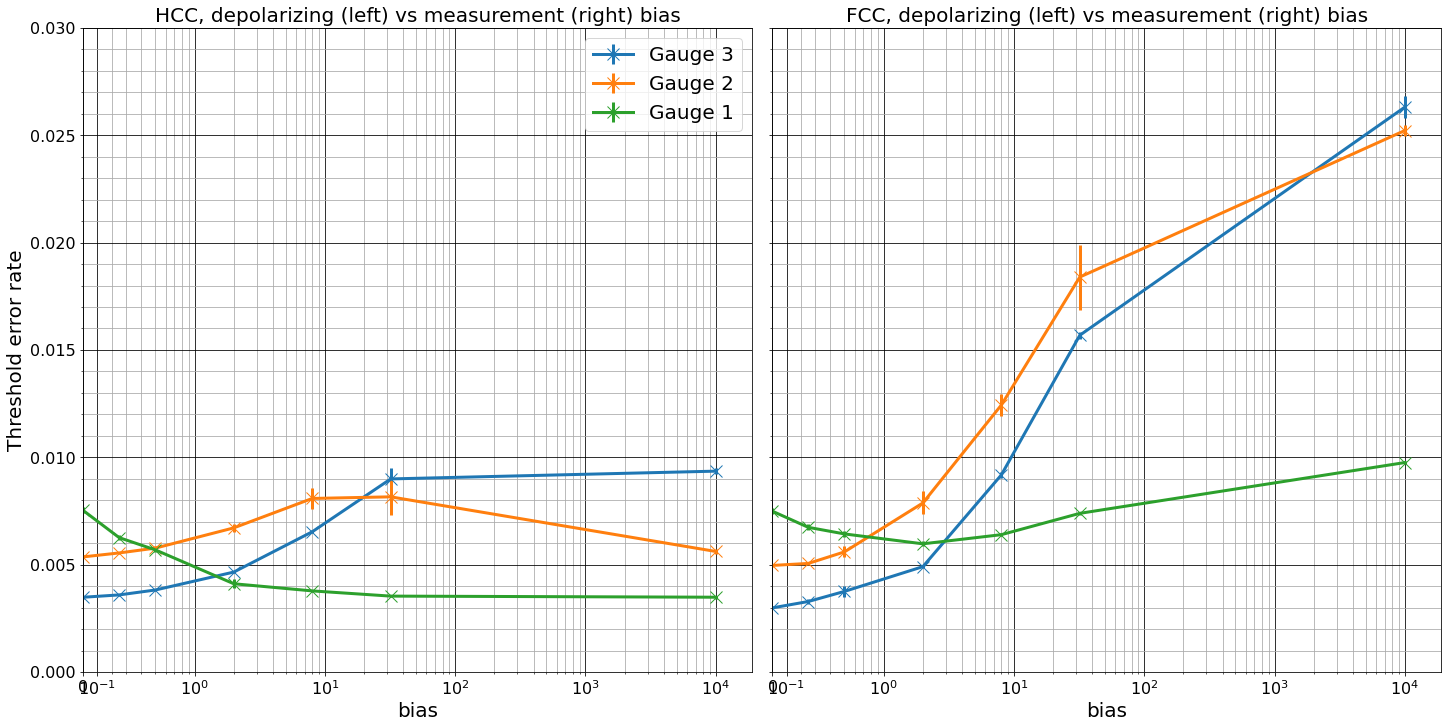

In [165]:
# make two axis.
fig, ax = plt.subplots(1,2,figsize=(20,10), sharey=True, constrained_layout=True)

biases = [bias for bias in thresholds_fcc3.keys()]
biases.sort()
plot_thresholds_hcc3 = [thresholds_hcc3[bias] for bias in biases]
plot_thresholds_hcc2 = [thresholds_hcc2[bias] for bias in biases]
plot_thresholds_fcc = [thresholds_fcc[bias] for bias in biases]
plot_thresholds_fcc2 = [thresholds_fcc2[bias] for bias in biases_fcc2]
plot_thresholds_hcc = [thresholds_hcc[bias] for bias in biases]
plot_thresholds_fcc3 = [thresholds_fcc3[bias] for bias in biases_fcc3]


ax[1].errorbar(biases, [thresholds_fcc3[bias][0] for bias in biases],yerr=[thresholds_fcc3[bias][1] for bias in biases], label='Gauge 3', marker='x',markersize=12, linewidth=3)
ax[1].errorbar(biases, [thresholds_fcc2[bias][0] for bias in biases],yerr=[thresholds_fcc2[bias][1] for bias in biases], label='Gauge 2', marker='x', markersize=12, linewidth=3)
ax[1].errorbar(biases, [thresholds_fcc[bias][0] for bias in biases],yerr=[thresholds_fcc[bias][1] for bias in biases],label='Gauge 1', marker='x', markersize=12, linewidth=3)
ax[0].errorbar(biases, [thresholds_hcc3[bias][0] for bias in biases],yerr=[thresholds_hcc3[bias][1] for bias in biases],label='Gauge 3', marker='x', markersize=12, linewidth=3)
ax[0].errorbar(biases, [thresholds_hcc2[bias][0] for bias in biases],yerr=[thresholds_hcc2[bias][1] for bias in biases],label='Gauge 2', marker='x', markersize=12, linewidth=3)
ax[0].errorbar(biases, [thresholds_hcc[bias][0] for bias in biases],yerr=[thresholds_hcc[bias][1] for bias in biases], label='Gauge 1', marker='x', markersize=12, linewidth=3)


for a in ax:
    a.set_xscale('symlog', linthresh = 0.5, subs = range(2, 10), linscale = 0.5)
    a.set_xlabel('bias', size=20)


    a.set_xlim(0,19000)
    a.grid(which='minor', color='#AAAAAA')
    a.grid(which='major', color='black')
    a.minorticks_on()
    a.tick_params(axis='both', which='major', labelsize=16)
    
ax[0].set_ylim(0,0.03)
ax[0].set_ylabel('Threshold error rate', size=20)
ax[0].set_title('HCC, depolarizing (left) vs measurement (right) bias', size=20)
ax[1].set_title('FCC, depolarizing (left) vs measurement (right) bias', size=20)
ax[0].legend(prop={'size': 20})

## Depolarizing vs dephasing noise

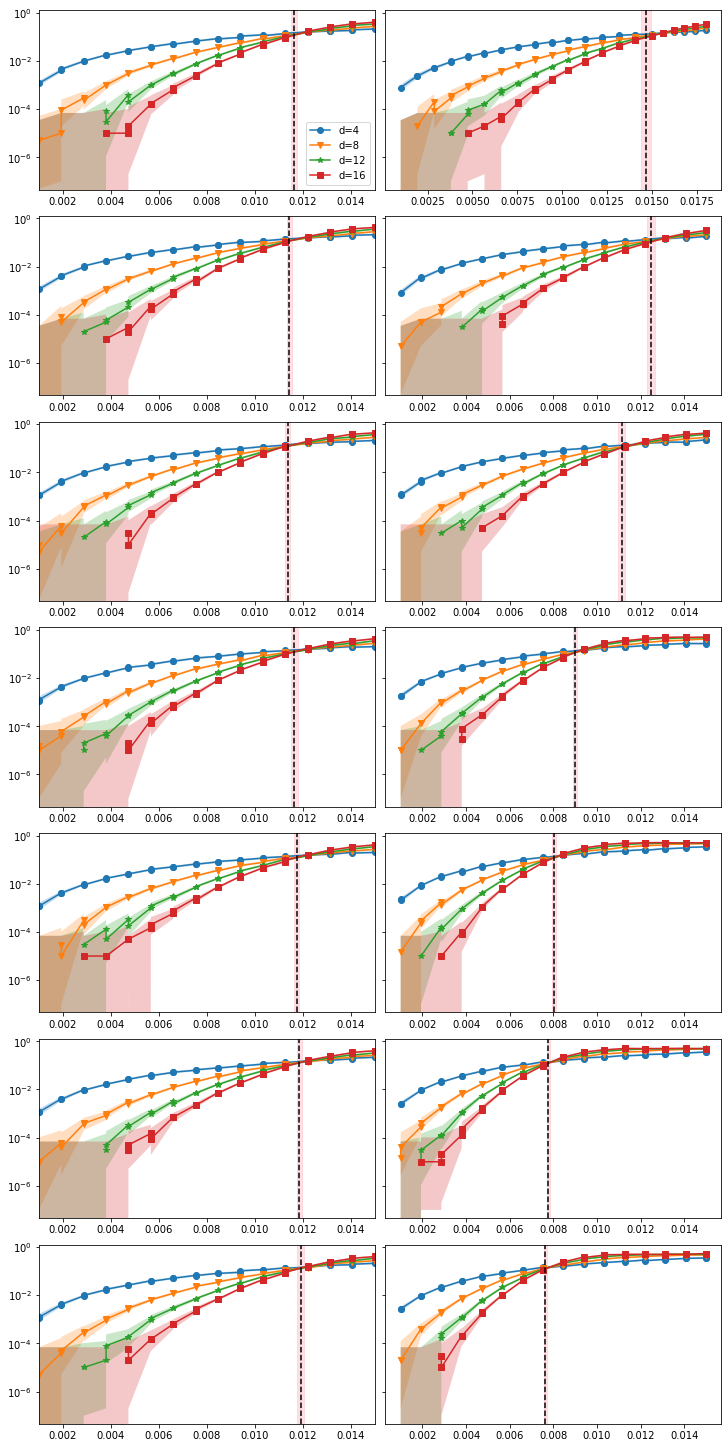

In [6]:
fig, axis = plt.subplots(7,2,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()
for index,bias in enumerate(biases):
    filter_func_hcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_dephasing'
    filter_func_fcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_dephasing'
    
    thresholds_hcc[bias] = plot_threshold(axis[index][0], samples,filter_func_hcc,0.006, 0.015, 5)
    thresholds_fcc[bias] = plot_threshold(axis[index][1], samples, filter_func_fcc, 0.005, 0.018, 5)

    axis[index][0].set_xlim(0.001,0.015)
    axis[0][0].legend()
    
all_thresholds_hcc['pymatching']['depolarizing_vs_dephasing'] = thresholds_hcc
all_thresholds_fcc['pymatching']['depolarizing_vs_dephasing'] = thresholds_fcc

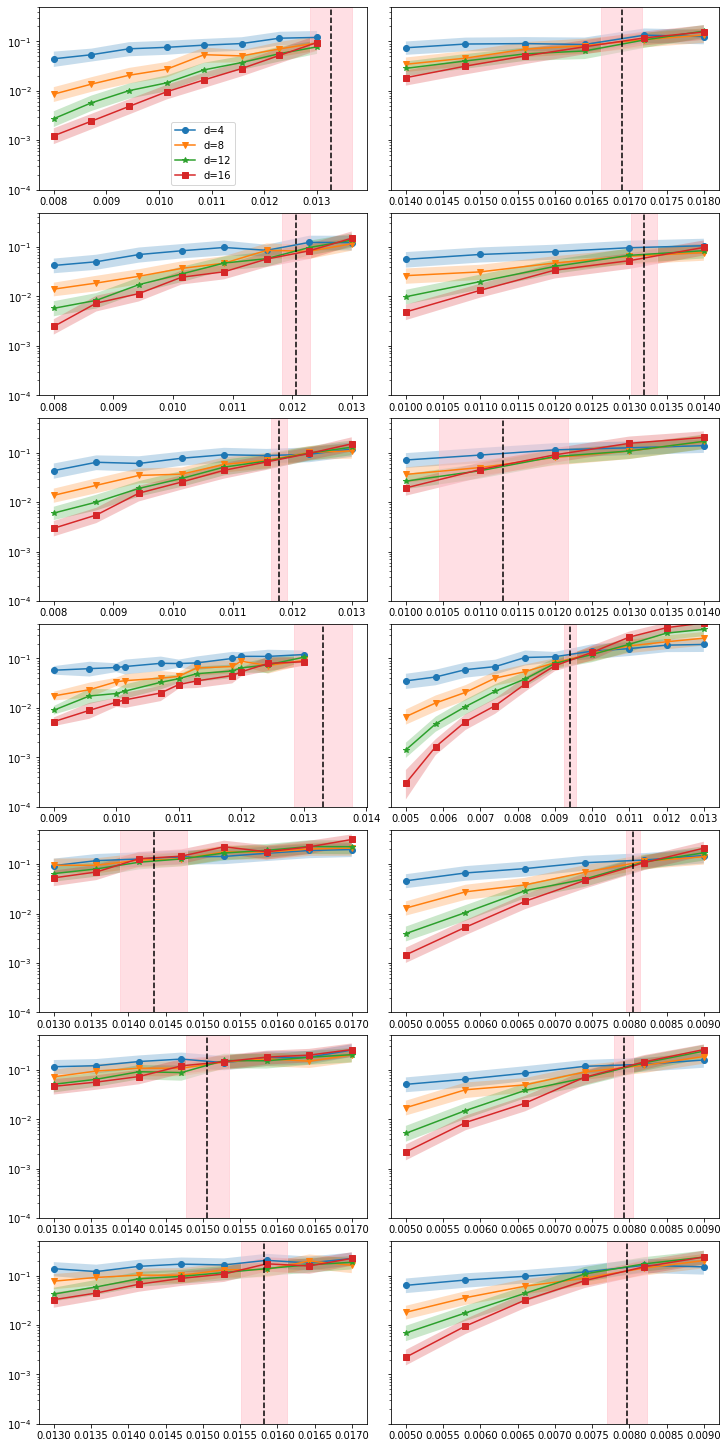

In [7]:
fig, axis = plt.subplots(7,2,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()
for index,bias in enumerate(biases):
    filter_func_hcc = lambda s : s.decoder == 'beliefmatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_dephasing'
    filter_func_fcc = lambda s : s.decoder == 'beliefmatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_dephasing'
    thresholds_hcc[bias] = plot_threshold(axis[index][0], samples,filter_func_hcc,0.005, 0.02, 5)
    thresholds_fcc[bias]= plot_threshold(axis[index][1], samples, filter_func_fcc,0.005, 0.02, 5)
    axis[0][0].legend()
    axis[index][0].set_ylim(10**-4, 0.5)
    axis[index][1].set_ylim(10**-4, 0.5)
all_thresholds_hcc['beliefmatching']['depolarizing_vs_dephasing'] = thresholds_hcc
all_thresholds_fcc['beliefmatching']['depolarizing_vs_dephasing'] = thresholds_fcc

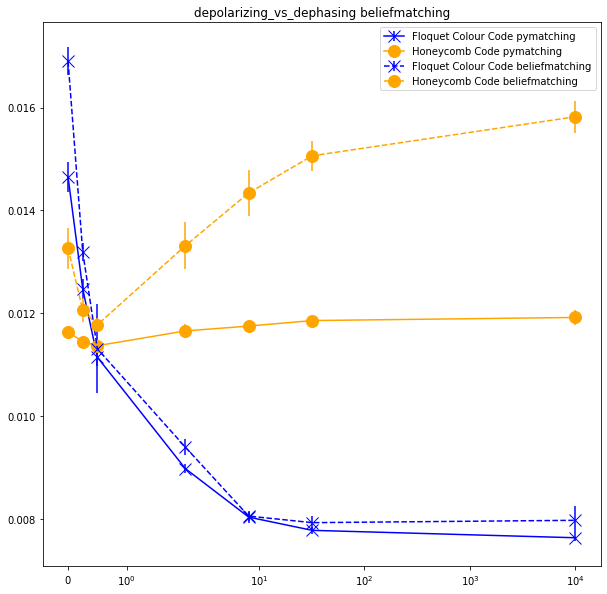

In [41]:
def plot_bias_vs_threshold(ax, thresholds_fcc, thresholds_hcc, decoder, bias_type, linestyle):
    biases = [bias for bias in thresholds_hcc[decoder][bias_type]]
    biases.sort()
    ax.errorbar(biases, [thresholds_fcc[decoder][bias_type][bias][0] for bias in biases], yerr=[
        thresholds_fcc[decoder][bias_type][bias][1] for bias in biases], label='Floquet Colour Code ' + str(decoder), marker='x', color='blue', linestyle=linestyle, markersize=12)
    ax.errorbar(biases, [thresholds_hcc[decoder][bias_type][bias][0] for bias in biases], yerr=[
                     thresholds_hcc[decoder][bias_type][bias][1] for bias in biases], label='Honeycomb Code ' + str(decoder), marker='o', color='orange', linestyle=linestyle, markersize=12)
    ax.set_xscale('symlog')
    ax.set_title(bias_type + " " + decoder)
    ax.legend()


fig, axs = plt.subplots(1, 1, figsize=(10, 10))


plot_bias_vs_threshold(axs, all_thresholds_fcc, all_thresholds_hcc,
                       'pymatching', 'depolarizing_vs_dephasing', 'solid')
plot_bias_vs_threshold(axs, all_thresholds_fcc, all_thresholds_hcc,
                       'beliefmatching', 'depolarizing_vs_dephasing', 'dashed')
plt.savefig('depolarizing_vs_dephasing.png')


## Depolarizing vs Y noise

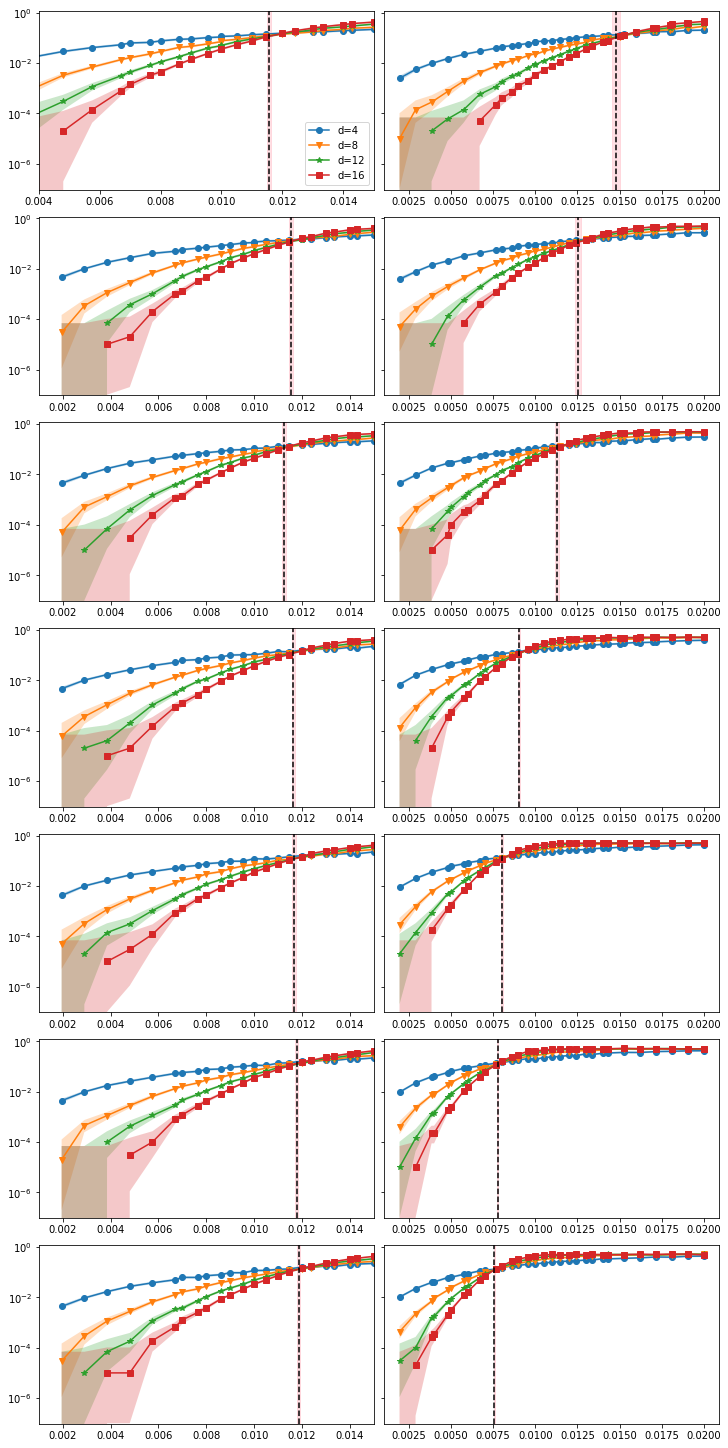

In [26]:
fig, axis = plt.subplots(7,2,figsize=(10,20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()

for index,bias in enumerate(biases):


    filter_func_hcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_y'
    filter_func_fcc = lambda s : s.decoder == 'pymatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'depolarizing_vs_y'

    if bias == 0: 
        thresholds_hcc[bias] = plot_threshold(axis[index][0], samples,filter_func_hcc,0.006, 0.015, 5)
        thresholds_fcc[bias] = plot_threshold(axis[index][1], samples, filter_func_fcc,0.005, 0.018, 5)
        axis[index][0].set_xlim(0.004,0.015)
    else:
        thresholds_hcc[bias] = plot_threshold(axis[index][0], samples, filter_func_hcc, 0.006, 0.015, 5)
        thresholds_fcc[bias] = plot_threshold(axis[index][1], samples, filter_func_fcc, 0.005, 0.015, 5)
        axis[index][0].set_xlim(0.001,0.015)
    axis[0][0].legend()

all_thresholds_hcc['pymatching']['depolarizing_vs_y'] = thresholds_hcc
all_thresholds_fcc['pymatching']['depolarizing_vs_y'] = thresholds_fcc

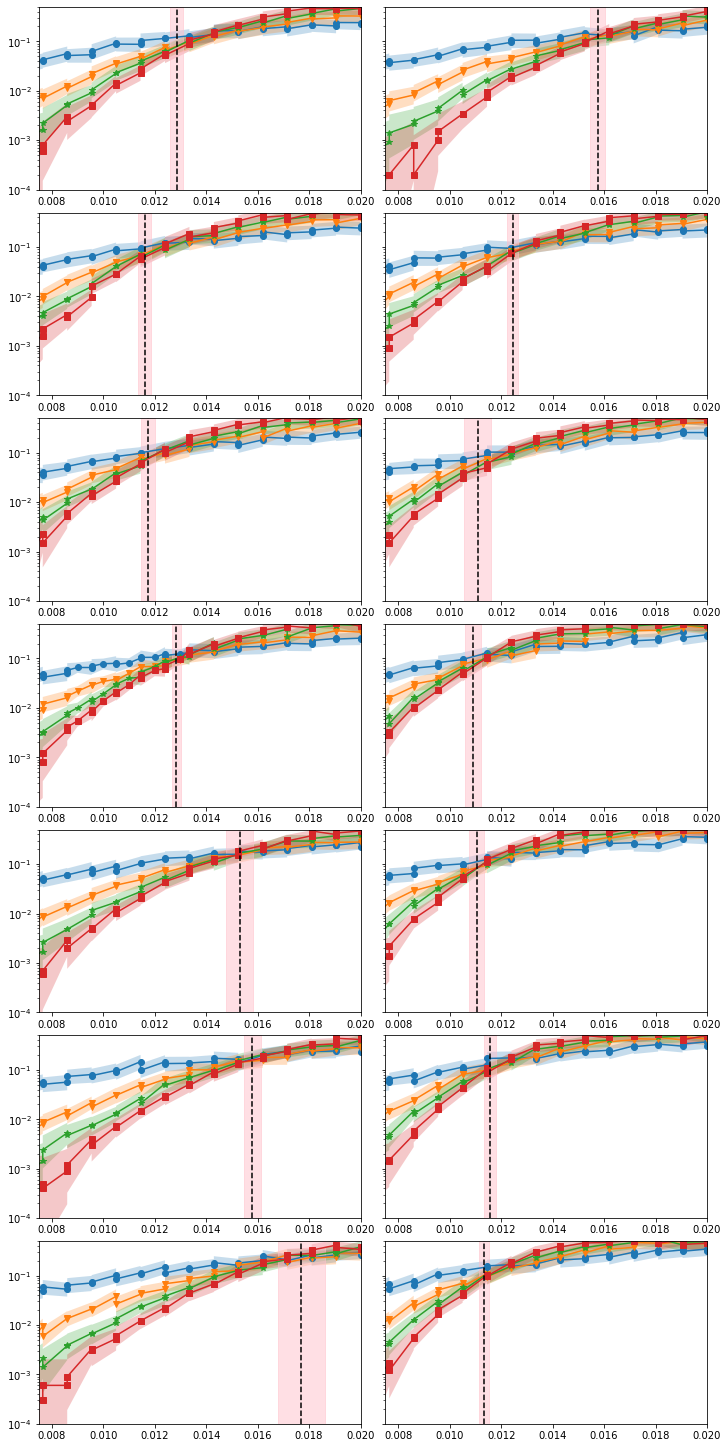

In [32]:
fig, axis = plt.subplots(7, 2, figsize=(10, 20), sharey=True, constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()


def filter_func_hcc(s): return s.decoder == 'beliefmatching' and s.json_metadata[
    'code'] == 'HoneycombCode' and s.json_metadata['bias'] == bias and s.json_metadata['bias_type'] == 'depolarizing_vs_y'


def filter_func_fcc(s): return s.decoder == 'beliefmatching' and s.json_metadata[
    'code'] == 'FloquetColourCode' and s.json_metadata['bias'] == bias and s.json_metadata['bias_type'] == 'depolarizing_vs_y'


for index, bias in enumerate(biases):


    thresholds_hcc[bias] = plot_threshold(axis[index][0], samples, filter_func_hcc, 0.0075, 0.017,5)
    thresholds_fcc[bias] =plot_threshold(axis[index][1], samples, filter_func_fcc, 0.0075, 0.017, 5)
    axis[index][0].set_xlim(0.0075, 0.02)
    axis[index][1].set_xlim(0.0075, 0.02)
    axis[index][0].set_ylim(10**-4, 0.5)
    axis[index][1].set_ylim(10**-4, 0.5)

all_thresholds_hcc['beliefmatching']['depolarizing_vs_y'] = thresholds_hcc
all_thresholds_fcc['beliefmatching']['depolarizing_vs_y'] = thresholds_fcc


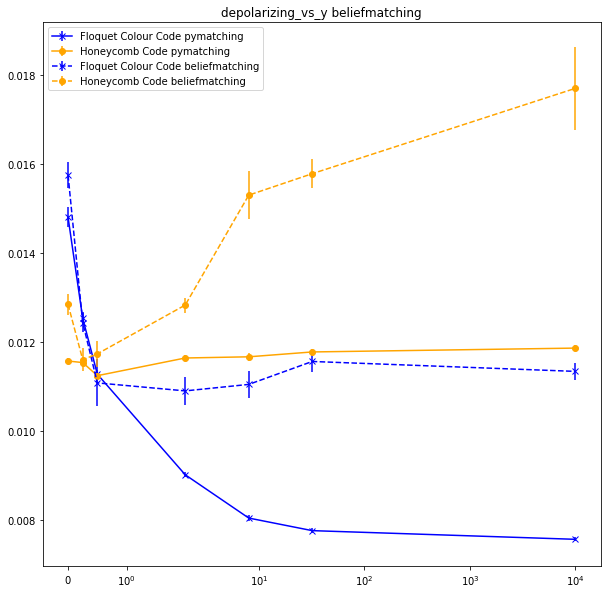

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

plot_bias_vs_threshold(axs, all_thresholds_fcc, all_thresholds_hcc,
                       'pymatching', 'depolarizing_vs_y', 'solid')
plot_bias_vs_threshold(axs, all_thresholds_fcc, all_thresholds_hcc,
                       'beliefmatching', 'depolarizing_vs_y', 'dashed')
plt.savefig('depolarizing_vs_dephasing.png')

# Depolarizing vs measurement

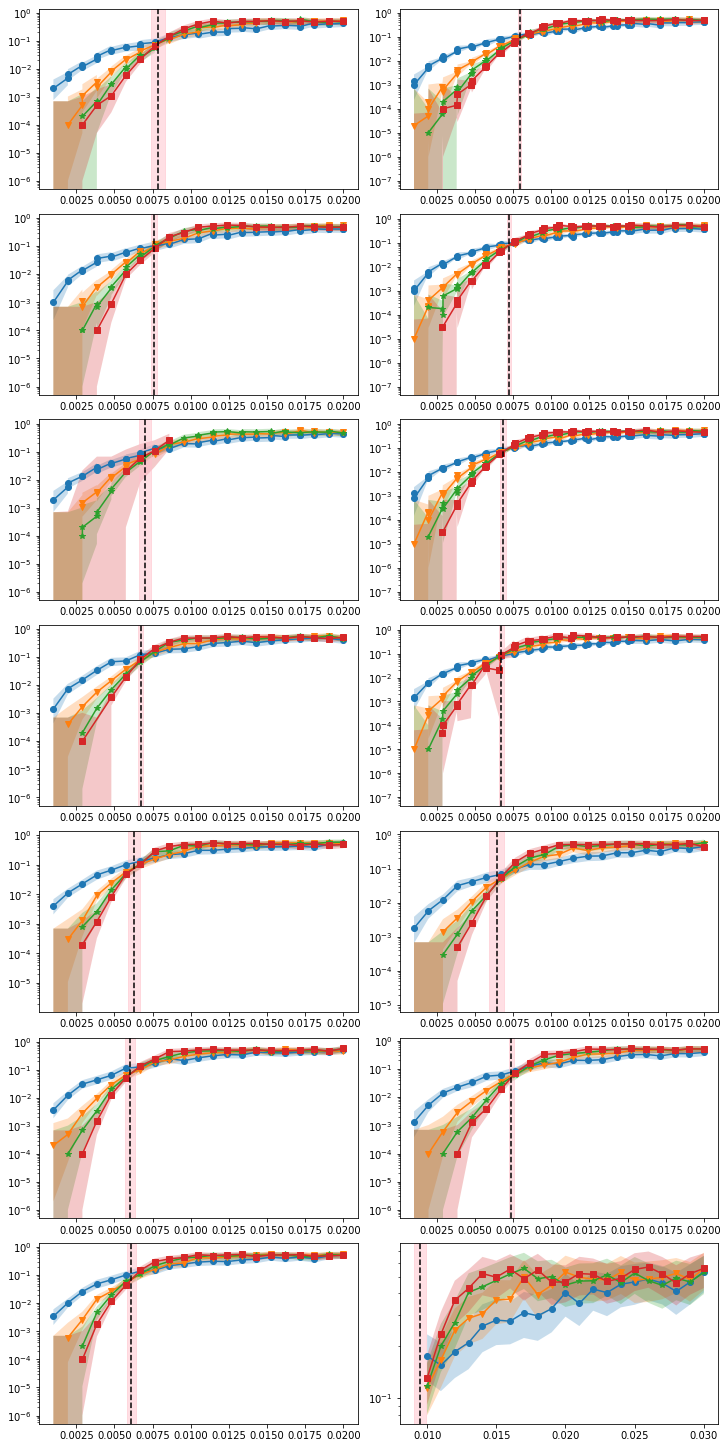

In [36]:
fig, axis = plt.subplots(7,2,figsize=(10,20), constrained_layout=True)
thresholds_hcc = dict()
thresholds_fcc = dict()
filter_func_hcc = lambda s : s.decoder == 'beliefmatching' and s.json_metadata['code'] == 'HoneycombCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
filter_func_fcc = lambda s : s.decoder == 'beliefmatching' and s.json_metadata['code'] == 'FloquetColourCode' and s.json_metadata['bias']==bias and s.json_metadata['bias_type'] == 'measurement_vs_data_qubit'
for index,bias in enumerate(biases):
    thresholds_hcc[bias] = plot_threshold(axis[index][0], samples, filter_func_hcc, 0.004, 0.015, 5)
    thresholds_fcc[bias] = plot_threshold(axis[index][1], samples, filter_func_fcc, 0.004, 0.015, 5)

all_thresholds_hcc['beliefmatching']['depolarizing_vs_measurement'] = thresholds_hcc
all_thresholds_fcc['beliefmatching']['depolarizing_vs_measurement'] = thresholds_fcc


KeyError: 'depolarizing_vs_dephasing'

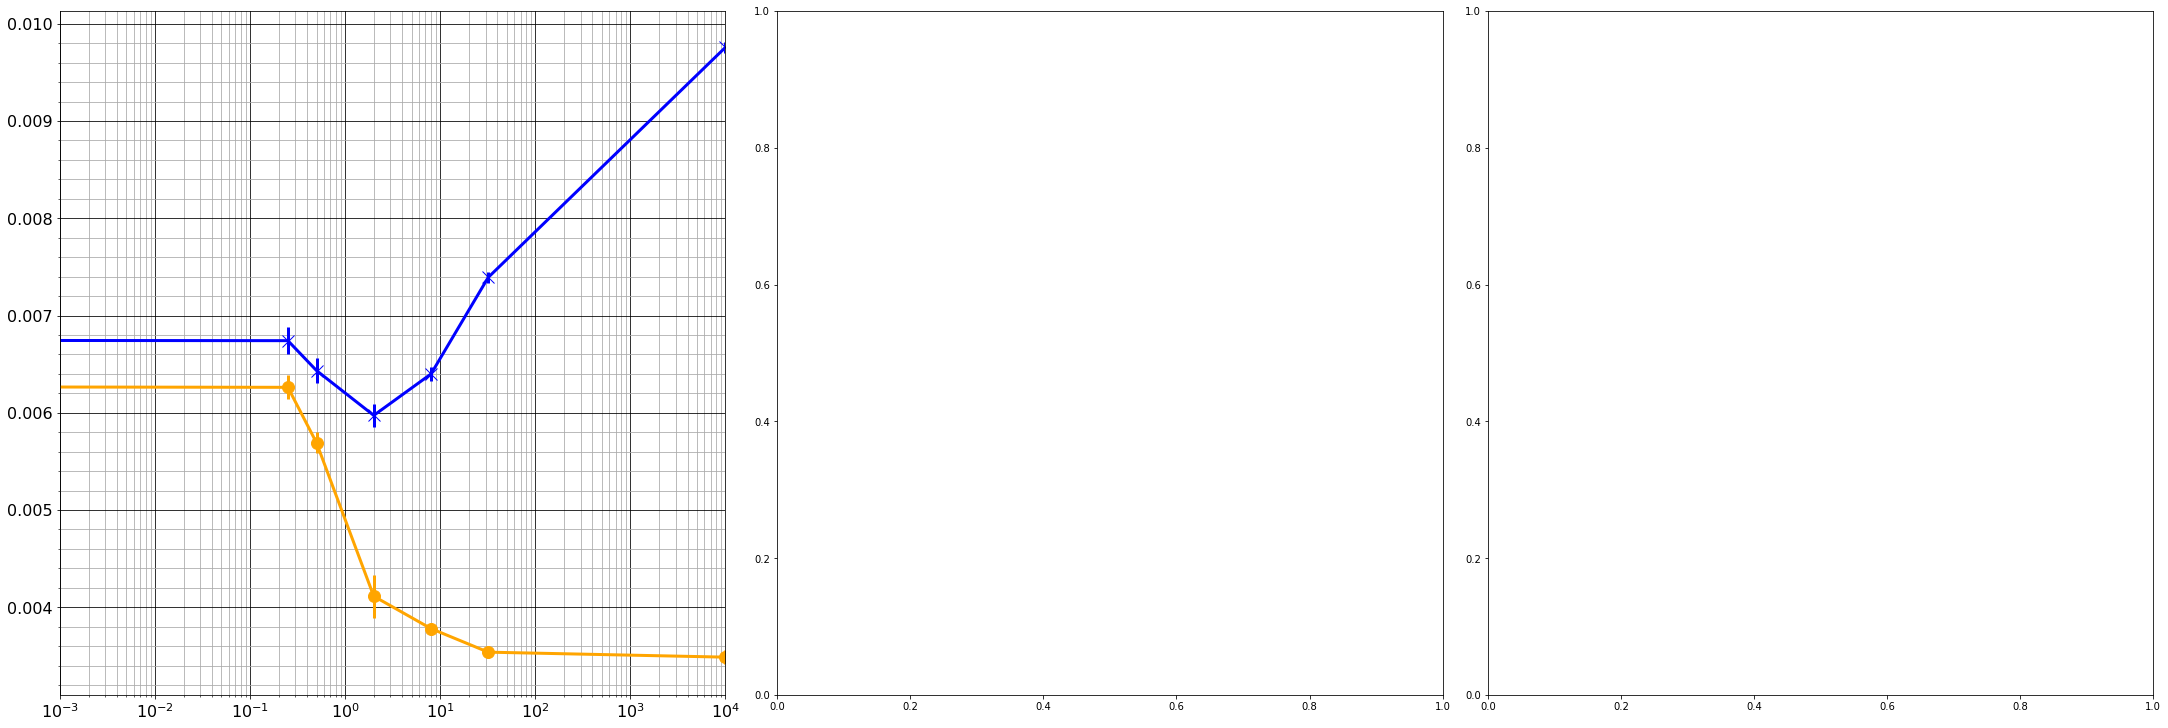

In [169]:
def plot_bias_vs_threshold(ax, thresholds_fcc, thresholds_hcc, decoder, bias_type, linestyle):
    biases = [bias for bias in thresholds_hcc[decoder][bias_type]]
    biases.sort()
    ax.errorbar([bias for bias in biases], [thresholds_fcc[decoder][bias_type][bias][0] for bias in biases], yerr=[
        thresholds_fcc[decoder][bias_type][bias][1] for bias in biases], label='Floquet Colour Code ' + str(decoder), marker='x', color='blue', linestyle=linestyle, markersize=12, linewidth=3)
    ax.errorbar([bias for bias in biases], [thresholds_hcc[decoder][bias_type][bias][0] for bias in biases], yerr=[
        thresholds_hcc[decoder][bias_type][bias][1] for bias in biases], label='Honeycomb Code ' + str(decoder), marker='o', color='orange', linestyle=linestyle, markersize=12, linewidth=3)
    #ax.set_xscale('symlog', linthresh=0.5, subs=range(2, 10),linscale=0.8)
    ax.minorticks_on()
    # increase ticksize to 10
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xscale('log')
    ax.grid(which='minor', color='#AAAAAA')
    ax.grid(which='major', color='black')
    ax.set_xlim(10**-3, 10**4)
    # include 0 in the x axis

fig, axs = plt.subplots(1,3,figsize=(30,10), constrained_layout=True)

plot_bias_vs_threshold(axs[0], all_thresholds_fcc, all_thresholds_hcc, 'pymatching', 'depolarizing_vs_measurement','solid')
plot_bias_vs_threshold(axs[1], all_thresholds_fcc, all_thresholds_hcc, 'pymatching', 'depolarizing_vs_dephasing','solid')
plot_bias_vs_threshold(axs[2], all_thresholds_fcc, all_thresholds_hcc, 'pymatching', 'depolarizing_vs_y','solid')

plot_bias_vs_threshold(axs[0], all_thresholds_fcc, all_thresholds_hcc, 'beliefmatching', 'depolarizing_vs_measurement','dashed')
plot_bias_vs_threshold(axs[1], all_thresholds_fcc, all_thresholds_hcc, 'beliefmatching', 'depolarizing_vs_dephasing','dashed')
plot_bias_vs_threshold(axs[2], all_thresholds_fcc, all_thresholds_hcc, 'beliefmatching', 'depolarizing_vs_y','dashed')

axs[0].legend(prop={'size': 20}, handlelength=4)
axs[0].set_title('Depolarizing vs Measurement', fontsize=30)
axs[1].set_title('XY vs Z', fontsize=30)
axs[2].set_title('XZ vs Y', fontsize=30)
axs[0].set_ylabel('Threshold Error Rate', fontsize=20)
axs[0].set_xlabel('Bias', fontsize=20)
axs[1].set_xlabel('Bias', fontsize=20)
axs[2].set_xlabel('Bias', fontsize=20)


